In [57]:
from collections import OrderedDict
from time import time
import re
import json
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

import math
from random import random, shuffle, choice

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

import numpy as np
from scipy.spatial import Delaunay

from matplotlib import collections  as mc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=False, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    return ax
#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




## load dot as networkx graph

  0%|          | 0/2588 [00:00<?, ?it/s]

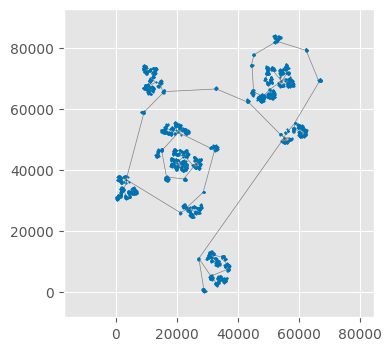

In [95]:
# !pip install pygraphviz

import pygraphviz as pgv

dot_fn = './data/external/in/lastfm/direct_lastfm_8.dot'
gv = pgv.AGraph(dot_fn, strict=False, directed=False)

G = nx.Graph(gv)
for i, node in tqdm(G.nodes(data=True)):
    node['pos'] = node['pos'].split(',')
    node['pos'] = [float(node['pos'][0]), float(node['pos'][1])]
    
pos = {i:node['pos'] for i,node in G.nodes(data=True)}
draw(G, pos, figsize=[4,4], s=1);

## grap attributes

In [90]:
node_id = natsorted(pos.keys())
node_x = [pos[n][0] for n in node_id]
node_y = [pos[n][1] for n in node_id]
node_index = list(range(len(node_id)))
node_level = [1] * len(node_id)
node_label = [G.nodes[i]['label'] for i in G.nodes]

edges = G.edges
edge_source = [int(e[0]) for e in edges]
edge_target = [int(e[1]) for e in edges]




out_fn = 'data/external/lastfm-CIR.json'

## write output json

In [97]:
out = dict(
    node_x=node_x,
    node_y=node_y,
    node_id=node_id,
    node_index=node_index,
    node_label=node_label,

    node_level=node_level, 

    edge_source=edge_source,
    edge_target=edge_target,
)
with open(out_fn, 'w') as f:
    json.dump(out, f)